## Import Required Library ##

In [36]:
#Import the needed library
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
#from numpy import genfromtxt

## EDA Analysis##

In [17]:
#I first load the training data and take a look to make sure that I understand the variables correctly.
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
train.tail()
train.info()
test.info()
# The data has 891 entry (about half of the passenger that boarded titanic)68% of the total dataset which has 1309 entry. 
#I noticed that age, cabin and embarked variables have missing data.  These are variables I will examine further in feature selection process. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [3]:
#below are a bunch of EDA type of command to check the values in the variables
#train_data.head()
#train=pd.DataFrame(train_data)
train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

## Data Wrangling ##

In [18]:
#Below is a bunch of data wrangling that I copied it from https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset

full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
# cabin number are string
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#PW added - curious if people with last name of a specific alphabet are more likely to die in the titanic
train['lastname_alphabet']=train['Name'].apply(lambda x: x[0])
test['lastname_alphabet']=test['Name'].apply(lambda x: x[0])

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;


In [6]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,lastname_alphabet,FamilySize,IsAlone,Title
886,887,0,2,"Montvila, Rev. Juozas",1,1,0,0,211536,1,NaN,0,0,M,1,1,5
887,888,1,1,"Graham, Miss. Margaret Edith",0,1,0,0,112053,2,B42,0,1,G,1,1,4
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,1,1,2,W./C. 6607,2,NaN,0,0,J,4,0,4
889,890,1,1,"Behr, Mr. Karl Howell",1,1,0,0,111369,2,C148,1,1,B,1,1,1
890,891,0,3,"Dooley, Mr. Patrick",1,1,0,0,370376,0,NaN,2,0,D,1,1,1


## Examine Features ##

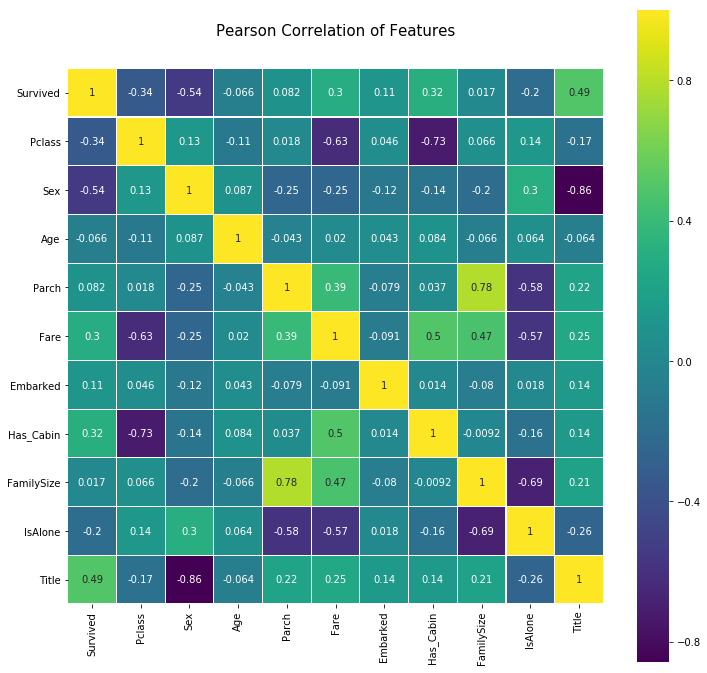

In [19]:
#I drop the elements that can not be put into numerical category
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','lastname_alphabet']
train_drop = train.drop(drop_elements, axis = 1)
test_drop  = test.drop(drop_elements, axis = 1)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_drop.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Survival rate has high absolute correlation with Sex, Title (associated with gender) which are as expeted. 

In [50]:
#Create train label which is 0,1 based on 'survived' column then drop the "survive" column from the train data. 

train_drop.tail()
train_label=train_drop['Survived']
#type (train_label)
train_data=train_drop.drop('Survived', axis=1)
#print(train_data)

# df = pd.DataFrame({'a':train_label})
# #df.groupby('a').count()
# df['a'].value_counts()

     Pclass  Sex  Age  Parch  Fare  Embarked  Has_Cabin  FamilySize  IsAlone  \
0         3    1    1      0     0         0          0           2        0   
1         1    0    2      0     3         1          1           2        0   
2         3    0    1      0     1         0          0           1        1   
3         1    0    2      0     3         0          1           2        0   
4         3    1    2      0     1         0          0           1        1   
5         3    1    2      0     1         2          0           1        1   
6         1    1    3      0     3         0          1           1        1   
7         3    1    0      1     2         0          0           5        0   
8         3    0    1      2     1         0          0           3        0   
9         2    0    0      0     2         1          0           2        0   
10        3    0    0      1     2         0          1           3        0   
11        1    0    3      0     2      

0    549
1    342
Name: a, dtype: int64

Since the test data set does not have survive variables, I will devde the training data set into train and test. 

In [56]:
X, Y=train_data, train_label
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
#I can't get the shuffle to work. I think it's because these are numpy array
#print(shuffle)
#X,Y=X[shuffle],Y[shuffle]

new_train, new_train_labels=X[:700],Y[:700]
new_test, new_test_labels=X[700:],Y[700:]

In [66]:
#DT criterion ("gini" or "entropy")
dt = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=0).fit(new_train, new_train_labels)

print ('Accuracy (a decision tree):', dt.score(new_test, new_test_labels))

#RFC n_estimators is the number of split - when it exceeds a certain threshold, it gives the same accuracy as a DT
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(new_train, new_train_labels)

print ('Accuracy (a random forest):', rfc.score(new_test, new_test_labels))

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100, learning_rate=0.1)

abc.fit(new_train, new_train_labels)
print ('Accuracy (adaboost with decision trees):', abc.score(new_test, new_test_labels))

Accuracy (a decision tree): 0.8586387434554974
Accuracy (a random forest): 0.8534031413612565
Accuracy (adaboost with decision trees): 0.837696335078534
